In [101]:
%matplotlib inline
from astropy.coordinates import SkyCoord
from astropy.io import ascii
from astroquery.irsa_dust import IrsaDust
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.integrate import quad
from scipy.optimize import curve_fit
import sncosmo
import sys
import tables

if sys.version_info.major != 2 and sys.version_info.minor != 7:
    raise RuntimeError("This notebook only works for python 2.7")

In [102]:
# Define data format
class Photometry(tables.IsDescription):
    time = tables.Float64Col()
    flux = tables.Float32Col()
    flux_err = tables.Float32Col()
    mag = tables.Float32Col()
    mag_err = tables.Float32Col()
    telescope = tables.StringCol(16)
    instrument = tables.StringCol(16)
    filter_name = tables.StringCol(16)
    

class TransmissionCurve(tables.IsDescription):
    wavelength = tables.Float32Col()
    transmission = tables.Float32Col()

In [103]:
def create_photometry_datafile(data_filename):
    fp = tables.open_file(data_filename, mode="a", title='iPTF16abc')
    phot_group = fp.create_group(fp.root, "photometry", "Photometry Data")

    # P48
    table = fp.create_table(phot_group, "photometry", Photometry, "Light curve")
    table.attrs.FIELD_0_UNIT = "day"
    table.attrs.FIELD_1_UNIT = "Jy"
    table.attrs.FIELD_2_UNIT = "Jy"
    table.attrs.FIELD_3_UNIT = "AB mag"
    table.attrs.FIELD_4_UNIT = "AB mag"
    row = table.row
    data = ascii.read("forcepsffitdiff_d100151_f1_c11.out", format="ipac")
    for item in data:
        if item["MJD"] < 57470:
            continue
        row["time"] = item["MJD"]
        row["flux"] = item["flux"] * 10**(-item["zpmag"] / 2.5) * 3631  # Jy
        row["flux_err"] = abs(row["flux"]) * ((item["sigflux"] / item["flux"])**2 + (item["zprms"] / 2.5)**2)**0.5
        if item["flux"] >= 5. * item["sigflux"]:
            row["mag"] = -2.5 * np.log10(item["flux"]) + item["zpmag"]
            row["mag_err"] = ((2.5 * item["sigflux"] / item["flux"])**2 + item["zprms"]**2)**0.5
        else:
            row["mag"] = -2.5 * np.log10(5. * item["sigflux"]) + item["zpmag"]
            row["mag_err"] = 99
        row["telescope"] = "P48"
        row["instrument"] = "CFH12K"
        row["filter_name"] = "g"
        row.append()

    data = ascii.read("forcepsffitdiff_d3381_f2_c10.out", format="ipac")
    for item in data:
        if item["MJD"] < 57470:
            continue
        row["time"] = item["MJD"]
        row["flux"] = item["flux"] * 10**(-item["zpmag"] / 2.5) * 3631  # Jy
        row["flux_err"] = row["flux"] * ((item["sigflux"] / item["flux"])**2 + (item["zprms"] / 2.5)**2)**0.5
        if item["flux"] >= 5. * item["sigflux"]:
            row["mag"] = -2.5 * np.log10(item["flux"]) + item["zpmag"]
            row["mag_err"] = ((2.5 * item["sigflux"] / item["flux"])**2 + item["zprms"]**2)**0.5
        else:
            row["mag"] = -2.5 * np.log10(5. * item["sigflux"]) + item["zpmag"]
            row["mag_err"] = 99
        row["telescope"] = "P48"
        row["instrument"] = "CFH12K"
        row["filter_name"] = "R"
        row.append()

    # P60
    with open("Marshal_lc.txt", "r") as fp_txt:
        for item in fp_txt:
            items = item.split(",")
            if len(items) < 3:
                continue
            if not items[7].startswith("\"P60"):
                continue
            filter_name = items[2][1:-1]
            mag = float(items[4])
            mag_err = float(items[5])
            if mag > 90.:
                continue
            row["time"] = float(items[1]) - 2400000.5
            row["mag"] = mag
            row["mag_err"] = mag_err
            row["telescope"] = "P60"
            row["instrument"] = "SEDM"
            row["filter_name"] = filter_name
            row["flux"] = 10**(-mag/2.5) * 3631
            row["flux_err"] = 0.921 * row["mag_err"] * row["flux"]
            row.append()
            
    # LCOGT
    with open("Marshal_lc.txt", "r") as fp_txt:
        for item in fp_txt:
            items = item.split(",")
            if len(items) < 3:
                continue
            if not items[7].startswith("\"LCOGT"):
                continue
            filter_name = items[2][1:-1]
            mag = float(items[4])
            mag_err = float(items[5])
            if mag > 90.:
                continue
            row["time"] = float(items[1]) - 2400000.5
            row["mag"] = mag
            row["mag_err"] = mag_err
            row["telescope"] = "LCOGT-1m"
            row["instrument"] = ""
            row["filter_name"] = filter_name
            row["flux"] = 10**(-mag/2.5) * 3631
            row["flux_err"] = 0.921 * row["mag_err"] * row["flux"]
            row.append()
            
    # Swift Data
    with open("swift_phot.txt", "r") as fp_txt:
        for item in fp_txt:
            if item.startswith("#"):
                continue
            items = item.split("\t")
            obs_time = datetime.datetime.strptime(items[1].split(".")[0], "%Y-%m-%d %H:%M:%S")
            row["time"] = (obs_time - datetime.datetime(2000, 1, 1)).total_seconds() / 86400 + 51544
            row["flux"] = float(items[3]) * 1e-3  # mJy -> Jy
            row["flux_err"] = float(items[4]) * 1e-3  # mJy -> Jy
            row["telescope"] = "Swift"
            row["instrument"] = "UVOT"
            row["filter_name"] = items[8].strip()
            row["mag"] = -2.5 * np.log10(row["flux"] / 3631)
            row["mag_err"] = 1.0857 * row["flux_err"] / row["flux"]
            row.append()
        
    filter_group = fp.create_group(phot_group, "filters", "Filter transmission curves")
    for filter_name in ["g", "R"]:
        table = fp.create_table(filter_group, 
                                "P48_" + filter_name, TransmissionCurve, 
                                "P48 %s filter transmission" % filter_name)
        table.attrs.FIELD_0_UNIT = "Angstrom"
        table.attrs.FIELD_1_UNIT = "photons per Angstrom"
        transmission = np.genfromtxt("../filters/P48/P48_%s.dat" % filter_name,
                                     names=["wavelength", "transmission"])
        row = table.row
        for item in transmission:
            row["wavelength"] = item["wavelength"]
            row["transmission"] = item["transmission"]
            row.append()
    for filter_name in ["g", "r", "i"]:
        table = fp.create_table(filter_group, 
                                "P60_" + filter_name, TransmissionCurve, 
                                "P60 %s filter transmission" % filter_name)
        table.attrs.FIELD_0_UNIT = "Angstrom"
        table.attrs.FIELD_1_UNIT = "photons per Angstrom"
        transmission = np.genfromtxt("../filters/SEDm/%sband_eff.dat" % filter_name,
                                     names=["wavelength", "transmission"])
        row = table.row
        for item in transmission:
            row["wavelength"] = item["wavelength"]
            row["transmission"] = item["transmission"]
            row.append()

    fp.close()

In [104]:
data_filename = "../iPTF16abc.h5"
if not os.path.exists(data_filename):
    create_photometry_datafile(data_filename)

In [105]:
def read_data():
    lc = dict()
    filter_curves = dict()
    h5file = tables.open_file("../iPTF16abc.h5", mode="r")
    table = h5file.root.photometry.photometry
    # P48 light curve
    for filter_name in ["g", "R"]:
        key = "P48_%s" % filter_name
        data = np.array([(row["time"], row["flux"], row["flux_err"])
                         for row in table.where(
                             "(telescope == b'P48') & (filter_name == b'%s')" % filter_name)
                        ],
                        dtype=[("time", "f"), ("flux", "f"), ("flux_err", "f")])
        np.sort(data, order=["time"])
        lc[key] = data
    # P60 light curve
    for filter_name in ["g", "r", "i"]:
        key = "P60_%s" % filter_name
        data = np.array([(row["time"], row["flux"], row["flux_err"])
                         for row in table.where(
                             u"(telescope == b'P60') & (filter_name == b'%s')" % filter_name)
                        ],
                        dtype=[("time", "f"), ("flux", "f"), ("flux_err", "f")])
        np.sort(data, order=["time"])
        lc[key] = data
    # LCOGT light curve
    for filter_name in ["B", "V", "g", "r", "i"]:
        key = "LCOGT_" + filter_name
        data = np.array([(row["time"], row["flux"], row["flux_err"])
                         for row in table.where(
                             u"(telescope == b'LCOGT-1m') & (filter_name == b'%s')" % filter_name)
                        ],
                        dtype=[("time", "f"), ("flux", "f"), ("flux_err", "f")])
        np.sort(data, order="time")
        lc[key] = data
        
    # P48 filter curve
    table_groups = h5file.root.photometry.filters
    for filter_name in ["g", "R"]:
        key = "P48_%s" % filter_name
        table = table_groups._v_children[key]
        data = np.array([(row["wavelength"], row["transmission"])
                         for row in table],
                        dtype=[("wavelength", "f"), ("transmission", "f")])
        filter_curves[key] = data
    for filter_name in ["g", "r", "i"]:
        key = "P60_%s" % filter_name
        table = table_groups._v_children[key]
        data = np.array([(row["wavelength"], row["transmission"])
                         for row in table],
                        dtype=[("wavelength", "f"), ("transmission", "f")])
        filter_curves[key] = data
        
    h5file.close()
        
    return lc, filter_curves

In [106]:
lc, filter_curves = read_data()

In [107]:
for key in filter_curves:
    band = sncosmo.Bandpass(filter_curves[key]["wavelength"],
                            filter_curves[key]["transmission"],
                            name=key)
    sncosmo.registry.register(band)

Exception: p60_g already in registry. Use force=True to override.

In [108]:
params = {"ra": 203.689542, "dec": +13.853974, "z": 0.0232}

# Galactic extinction
pos = SkyCoord(params["ra"], params["dec"], frame="fk5", unit="deg")
table = IrsaDust.get_query_table(pos, section="ebv")
params["mwebv"] = float(table["ext SandF mean"])

# preparing fit datafile
with open("parameters.txt", "w") as fp:
    fp.write("@z %.3f\n" % params["z"])
    fp.write("@mwebv %.3f\n" % params["mwebv"])
    fp.write("@t %.3f\n" % 57500.)
    fp.write("time band flux fluxerr zp zpsys\n")
    zp = 2.5 * np.log10(3631)
    for key in ["P48_R", "P48_g", "P60_g", "P60_r", "P60_i"]:
        for row in lc[key]:
            if row["time"] < 57475 or row["time"] > 57570:
                continue
            fp.write("%9.3f  %s  %.4e  %.4e  %.3f  %s\n" %\
                     (row["time"], key, row["flux"], row["flux_err"],
                      zp, "ab"))

In [109]:
d = sncosmo.read_lc("parameters.txt", format="ascii")

dust = sncosmo.F99Dust()
host_dust = sncosmo.F99Dust()
model = sncosmo.Model(source="salt2",
                      effects=[host_dust, dust],
                      effect_names=["host", "mw"],
                      effect_frames=["rest", "obs"])
model.set(z=params["z"])
model.set(t0=57500.)
model.set(hostebv=0.332)
model.set(mwebv=d.meta["mwebv"])



In [110]:
fit_parameter_list = ["t0", "x0", "x1", "c"]

res, fitted_model = sncosmo.fit_lc(d, model, fit_parameter_list,
                                   bounds={"t0": (57490, 57510), 
                                           "x1": (-5, 5)},
                                   guess_x0=False,
                                   guess_t0=False)

       errors: OrderedDict([('t0', 0.023515140306699323), ('x0', 0.000217625358767583), ('x1', 0.04303672270392411), ('c', 0.005404662036543707)])
   parameters: array([  2.32000000e-02,   5.74996497e+04,   2.75431650e-02,
         1.20050973e+00,  -3.35263689e-01,   3.32000000e-01,
         2.40000000e-02])
      success: True
         ndof: 88
   covariance: array([[  5.52962844e-04,  -3.00748838e-06,   8.93702668e-04,
          5.46778275e-05],
       [ -3.00748838e-06,   4.73607968e-08,  -7.02312687e-06,
         -1.04036958e-06],
       [  8.93702668e-04,  -7.02312687e-06,   1.85220804e-03,
          1.23650596e-04],
       [  5.46778275e-05,  -1.04036958e-06,   1.23650596e-04,
          2.92103717e-05]])
 vparam_names: ['t0', 'x0', 'x1', 'c']
        chisq: 1342.5666862162454
  param_names: ['z', 't0', 'x0', 'x1', 'c', 'hostebv', 'mwebv']
      message: 'Minimization exited successfully.'
        ncall: 171


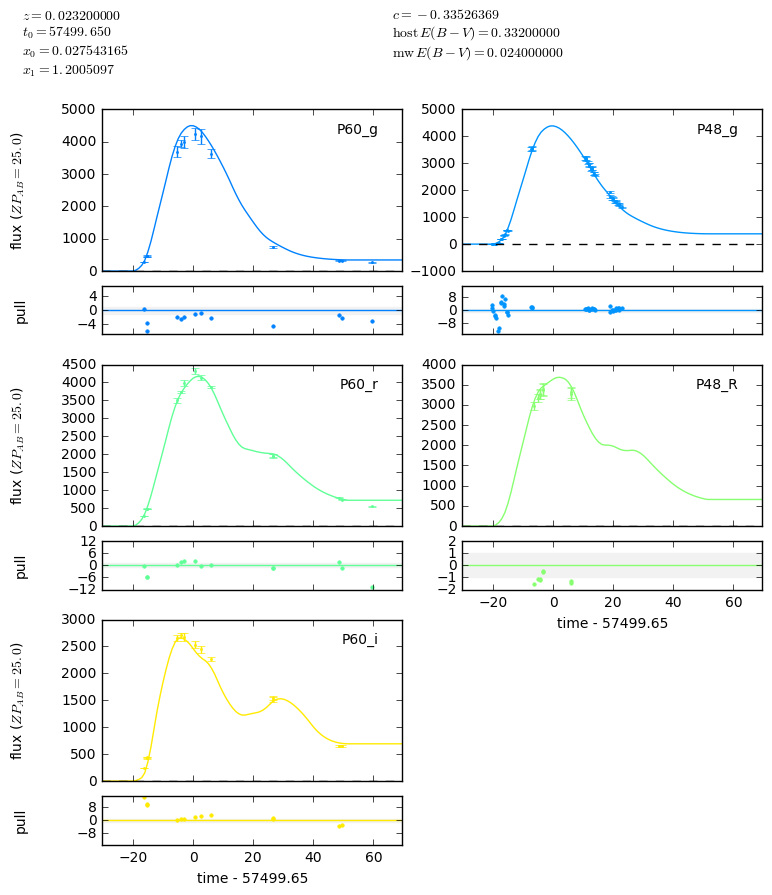

In [111]:
fig = sncosmo.plot_lc(d, model=fitted_model, error=res.errors)
print res

In [112]:
fitted_model.source_peakmag(sncosmo.get_bandpass("bessellb"), 'ab')

14.395871309453982

In [113]:
def EarlyLCModel(t, t0, alpha, C):
    return np.where(t > t0, 10**(C) * (t - t0)**alpha, 0)

In [114]:
g_lc = np.concatenate([lc["P48_g"], lc["P60_g"], lc["LCOGT_g"]])
g_lc.sort(order="time")
idx = np.logical_and(g_lc["time"] > 57479, g_lc["time"] < 57485)
early_lc = g_lc[idx]
t0_range = np.linspace(57480, 57482, 201)
alpha_range = np.linspace(0.5, 2.5, 101)
C_range = np.linspace(-6, -3, 301)
X, Y, Z = np.meshgrid(t0_range, alpha_range, C_range)
chi2 = np.ndarray(X.shape)
l, m, n = chi2.shape
for i in range(l):
    for j in range(m):
        for k in range(n):
            chi2[i][j][k] = np.sum(
                ((early_lc["flux"] - EarlyLCModel(early_lc["time"], X[i][j][k], Y[i][j][k], Z[i][j][k])) /\
                 early_lc["flux_err"])**2)
chi2 -= np.min(chi2)
idx = np.where(chi2 == 0.0)
t0 = X[idx]
alpha = Y[idx]
C = Z[idx]

/Users/ycao/python/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app
/Users/ycao/python/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in power
  from ipykernel import kernelapp as app


/Users/ycao/python/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in power
  from ipykernel import kernelapp as app


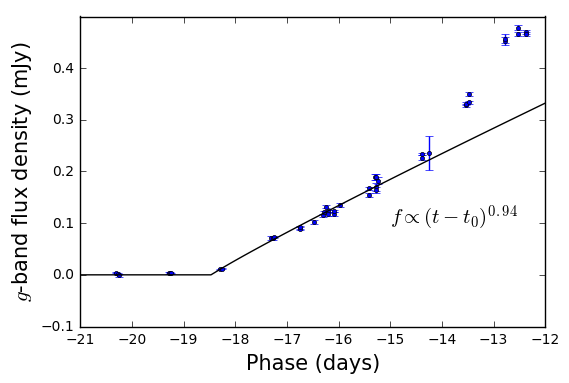

In [126]:
plt.errorbar(g_lc["time"] - 57499.65, g_lc["flux"] * 1e3, 
             yerr=g_lc["flux_err"] * 1e3, 
             linestyle='none',
             marker='o',
             markersize=3)
t = np.linspace(-3, 10, 101) + t0
plt.plot(t - 57499.65, EarlyLCModel(t, t0, alpha, C) * 1e3, 'k-')

plt.xlabel("Phase (days)", fontsize=15)
plt.ylabel("$g$-band flux density (mJy)", fontsize=15)
plt.xlim(-21, -12)
plt.ylim(-0.1, 0.5)
plt.text(-15, 0.10, "$f\\propto (t-t_0)^{%.2f}$" % alpha, fontsize=15)
plt.savefig("early_lc.pdf")

(0.8, 2.2)

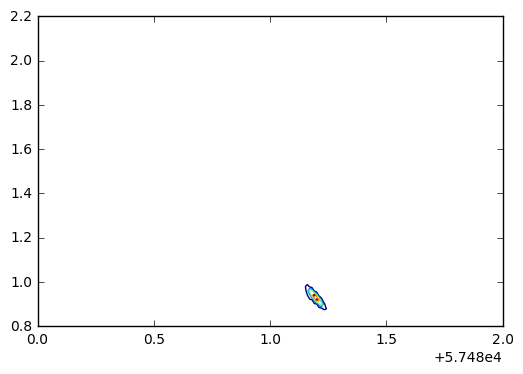

In [116]:
prob = np.sum(np.exp(-chi2 / 2), axis=2)
prob /= np.sum(prob)
X, Y = np.meshgrid(t0_range, alpha_range)
plt.contour(X, Y, prob)
plt.xlim(57480, 57482)
plt.ylim(0.8, 2.2)

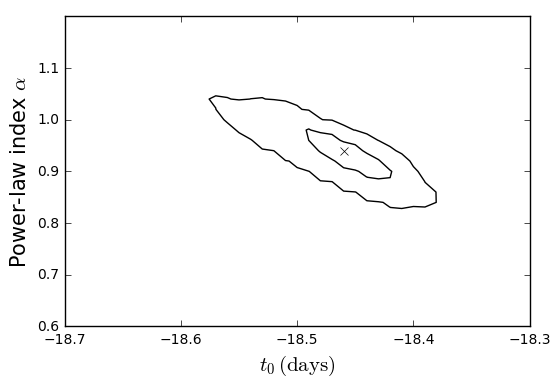

In [120]:
t_max = 57499.65
flat_prob = prob.flatten()
flat_prob.sort()
total = 0
one_sigma = -1
three_sigma = -1
for num in flat_prob[::-1]:
    total += num
    if one_sigma < 0 and total > 0.68:
        one_sigma = num
    if three_sigma < 0 and total > 0.997:
        three_sigma = num
contour = plt.contour(X - t_max, Y, prob, [three_sigma, one_sigma],
                      colors="k")
plt.plot(t0 - t_max, alpha, 'x', color="k", linestyle='none')
plt.xlim(-18.7, -18.3)
plt.ylim(0.6, 1.2)
plt.xticks(np.arange(-18.70, -18.20, 0.1))
plt.xlabel("$t_0\\,\\rm{(days)}$", fontsize=15)
plt.ylabel("Power-law index $\\alpha$", fontsize=15)
plt.savefig("rise_time_power_law_index.pdf")

<Container object of 3 artists>

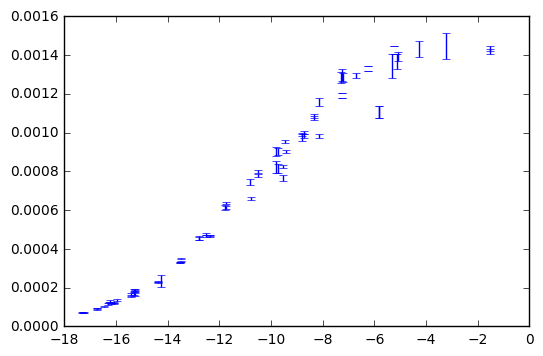

In [66]:
g_lc = np.concatenate([lc["P48_g"], lc["P60_g"], lc["LCOGT_g"]])
g_lc.sort(order="time")
idx = np.logical_and(g_lc["time"] > 57499.65 - 18, 
                     g_lc["time"] < 57499.65)
plt.errorbar(g_lc["time"][idx] - 57499.65, g_lc["flux"][idx], 
             yerr=g_lc["flux_err"][idx], linestyle='none')